In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
from dream.data_utils import load_data_with_trained_model

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm

In [3]:
data_name = 'drebin'
feature_name = 'damd'

from dream.load_data import get_dataset_family
dataset_families = get_dataset_family(data_name)
num_family = len(dataset_families)
newfamily = 0

x_train, (y_train, yb_train), x_test, (y_test, yb_test), dream_model = load_data_with_trained_model(data_name, feature_name, newfamily, num_family, dream=True)
x_train, (y_train, yb_train), x_test, (y_test, yb_test), cade_model = load_data_with_trained_model(data_name, feature_name, newfamily, num_family, dream=False)

2024-10-07 15:30:50.136859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 15:30:50.589110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46712 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [4]:
emb_dream_train = dream_model.encoder.predict(x_train) # (n_samples, n_features)
emb_dream_test = dream_model.encoder.predict(x_test)

2024-10-07 15:31:07.594503: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [5]:
label_names_ = [string for i, string in enumerate(dataset_families) if i != newfamily]
label_names = {i: string for i, string in enumerate(label_names_)}
label_names[num_family-1] = dataset_families[newfamily]
# Automatically generate colors from a colormap
colormap = cm.get_cmap('tab10', num_family)  # 'tab10' is a colormap with 10 distinct colors
label_colors = {i: colormap(i) for i in range(num_family)}

# label_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'pink', 4: 'orange'}

In [18]:
def get_top_k_mask(drifting_scores, k):
    # Ensure that k does not exceed the number of elements
    k = min(k, len(drifting_scores))
    if k <= 0:
        return np.zeros_like(drifting_scores, dtype=bool)
    if k >= len(drifting_scores):
        return np.ones_like(drifting_scores, dtype=bool)
    
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(-drifting_scores)
    top_k_indices = sorted_indices[:k]  
    # Create the boolean mask
    mask = np.zeros_like(drifting_scores, dtype=bool)
    mask[top_k_indices] = True
    
    return mask

def get_top_drifting_masks(data_name, feature_name, newfamily, k, detector='dream', y_true=None):
    contents = np.load(os.path.join('results', data_name, feature_name.capitalize(), f'{detector}_mean_roc.npz'), allow_pickle=True)
    drifting_scores = contents['drift_scores'][newfamily]
    if y_true is not None:
        from dream.evaluate import count_correct_in_top_k
        drift_labels = contents['drift_labels'][newfamily]
        correct_num = count_correct_in_top_k(drifting_scores, drift_labels, k)
        print(f'{detector}: {correct_num}/{k}')
    return get_top_k_mask(drifting_scores, k)

In [59]:
def plot_tsne(X, labels, label_names, label_colors, test_data=None, drift_test=True, mask=None):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    if test_data is None:
        X_tsne = tsne.fit_transform(X)
    else:
        X_test, label_test = test_data
        X_tsne_ = tsne.fit_transform(np.concatenate([X, X_test]))
        X_tsne = X_tsne_[:len(X)]
        X_tsne_test = X_tsne_[len(X):]

    # Compute centroids
    centroids = np.array([X_tsne[labels == label].mean(axis=0) for label in np.unique(labels)])
    class_sizes = np.array([np.sum(labels == label) for label in range(num_family)])

    # Plot points
    plt.figure(figsize=(8, 7))
    # for label in np.unique(labels):
    #     indices = labels == label
    #     plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], 
    #                 color=label_colors[label], s=5, marker='x') # , label=label_names[label]
    if test_data is not None:
        for label in np.unique(label_test):
            if drift_test and label!=num_family-1:
                continue
            indices = label_test == label
            if mask is None:
                plt.scatter(X_tsne_test[indices, 0], X_tsne_test[indices, 1], 
                            color=label_colors[label], edgecolors='black' if label==num_family-1 else 'none', 
                            label='Drift Samples', s=50) # +label_names[label]
            else:
                plt.scatter(X_tsne_test[indices & ~mask, 0], X_tsne_test[indices & ~mask, 1], 
                            color=label_colors[label], edgecolors='none', 
                            label='Drift Samples', s=50) # +label_names[label]
                plt.scatter(X_tsne_test[indices & mask, 0], X_tsne_test[indices & mask, 1], 
                            color=label_colors[label], edgecolors='black', 
                            s=50) # +label_names[label]

    # Plot centroids with class name tagged
    for i, label in enumerate(np.unique(labels)):
        # plt.scatter(centroids[i, 0], centroids[i, 1], 
        #             color=label_colors[label], s=200, marker='o')
        plt.scatter(centroids[i, 0], centroids[i, 1], 
                color=label_colors[label], s=class_sizes[i] * 5,  # Size proportional to class size
                alpha=0.5, edgecolor='black' if label == 7 else 'none', marker='o')
        plt.text(centroids[i, 0], centroids[i, 1], label_names[label], fontsize=13, ha='center', va='center')

    # plt.title('t-SNE plot with class centroids and labels')
    # plt.xlabel('t-SNE component 1')
    # plt.ylabel('t-SNE component 2')
    ax = plt.gca()
    ax.set_xlim([-100,120])
    ax.set_ylim([-130,120])
    plt.legend(fontsize=13, handleheight=1.2, markerscale=1.2, loc='upper left')
    plt.show()

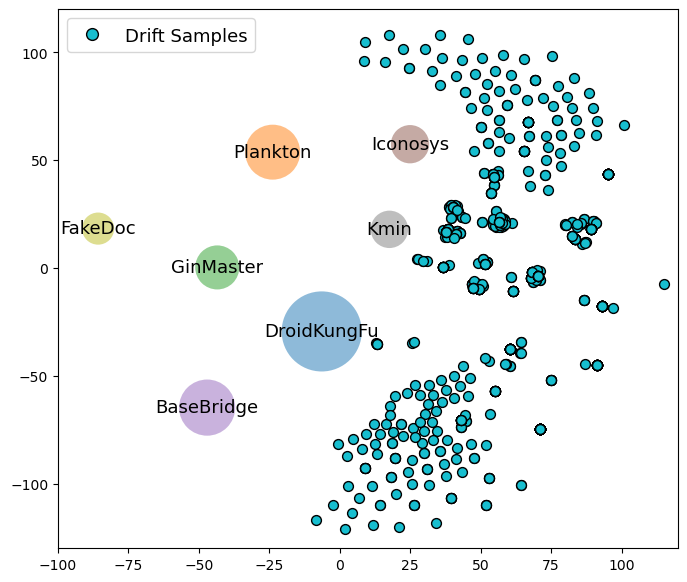

In [83]:
# mask_dream = get_top_drifting_masks(data_name, feature_name, newfamily, 900, detector='dream', y_true=y_test)
plot_tsne(emb_dream_train, y_train, label_names, label_colors, (emb_dream_test, y_test)) #, mask=mask_dream

In [61]:
emb_cade_train = cade_model.encoder.predict(x_train) # (n_samples, n_features)
emb_cade_test = cade_model.encoder.predict(x_test)

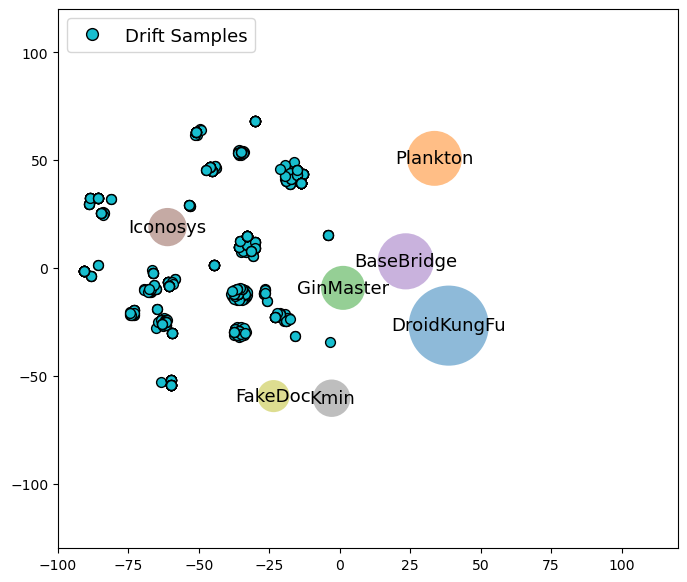

In [84]:
# Apply t-SNE
# mask_cade = get_top_drifting_masks(data_name, feature_name, newfamily, 900, detector='cade', y_true=y_test)
plot_tsne(emb_cade_train, y_train, label_names, label_colors, (emb_cade_test, y_test)) #, mask=mask_cade

In [112]:
from dream.evaluate import count_correct_in_top_k
import pandas as pd

def get_correct_count(data_name, feature_name):
    overall_results = []
    for k in [10, 20, 30, 40, 100]:
        results = {}
        for detector in ['basic', 'transcendent', 'cade', 'dream']:
            results[detector] = []
            contents = np.load(os.path.join('results', data_name, feature_name.capitalize(), f'{detector}_mean_roc.npz'), allow_pickle=True)
            for newfamily in range(num_family):
                drifting_scores = contents['drift_scores'][newfamily]
                drift_labels = contents['drift_labels'][newfamily]
                correct_num = count_correct_in_top_k(drifting_scores, drift_labels, k)
                results[detector].append(correct_num)
        results = pd.DataFrame(results).mean().to_frame().T
        results.index = [k]
        overall_results.append(results)
    return pd.concat(overall_results)

for data_name in ['drebin', 'malradar']:
    for feature_name in ["drebin", "mamadroid", "damd"]:
        print(f'Dataset [{data_name}], Feature [{feature_name}]')
        get_correct_count(data_name, feature_name)

,basic,transcendent,cade,dream
10,7.875,5.00,6.750,8.375
20,16.375,11.75,15.875,17.875
30,24.875,21.75,25.750,27.625
40,33.500,31.75,35.625,37.500
100,80.250,91.75,94.625,96.250


## Activation Diff

In [ ]:
data_name = 'drebin'
feature_name = 'drebin'

from dream.load_data import get_dataset_family
dataset_families = get_dataset_family(data_name)
num_family = len(dataset_families)
newfamily = 1

x_train, (y_train, yb_train), x_test, (y_test, yb_test), dream_model = load_data_with_trained_model(data_name, feature_name, newfamily, num_family, dream=True)
x_train, (y_train, yb_train), x_test, (y_test, yb_test), cade_model = load_data_with_trained_model(data_name, feature_name, newfamily, num_family, dream=False)

In [11]:
dream_model.f1.summary()

Model: "DrebinMLP_f1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clf_0 (Dense)               (None, 100)               116900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 clf_1 (Dense)               (None, 30)                3030      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 clf_2 (Dense)               (None, 7)                 217       
                                                                 
Total params: 120,147
Trainable params: 120,147
Non-trainable params: 0
_________________________________________________________________


In [12]:
cade_model.f1.summary()

Model: "DrebinMLP_f1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clf_0 (Dense)               (None, 100)               116900    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 clf_1 (Dense)               (None, 30)                3030      
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 clf_2 (Dense)               (None, 7)                 217       
                                                                 
Total params: 120,147
Trainable params: 120,147
Non-trainable params: 0
_________________________________________________________________


In [13]:
X_drift = x_test[y_test==num_family-1]

In [14]:
from tensorflow.keras.models import Model

def visualize_feature_map(model, X_test, layer_names=['conv1d', 'conv1d_1']):
    try:
        # If there's an explicit InputLayer
        input_layer = model.get_layer(index=0)
    except ValueError:
        # If there's no explicit InputLayer
        input_layer = model.input

    # Create models to output feature maps
    feature_map_models = [Model(inputs=input_layer.input, outputs=model.get_layer(name).output) for name in layer_names]

    # Generate feature maps
    feature_maps = [model.predict(X_test) for model in feature_map_models]

    # Plot the feature maps for each layer
    for i, fmap in enumerate(feature_maps):
        plt.figure(figsize=(15, 15))
        plt.suptitle(f'Feature Maps for {layer_names[i]}')
        if len(fmap.shape) > 2:
            num_channels = fmap.shape[-1]
            for j in range(num_channels):
                plt.subplot(num_channels, 1, j + 1)  # Plotting as line plots
                plt.plot(fmap[0, :, j])
                plt.axis('off')
        else:
            plt.plot(fmap[0])
            plt.axis('off')
        plt.show()

In [15]:
# visualize_feature_map(dream_model.f1, X_drift[:1], layer_names=['dropout'])

In [16]:
def visualize_cam_1d(model, X_test, layer_names=['conv1d', 'conv1d_1'], pred_layer_name='dense_1', del_emb=False, valid_positions=None, tabular=False, color=None, label='Original'):
    def compute_cam(model, last_conv_layer_name, pred_layer_name, input_data):
        if del_emb:
            input_layer = model.get_layer(index=1)
        else:
            try:
                # If there's an explicit InputLayer
                input_layer = model.get_layer(index=0)
            except ValueError:
                # If there's no explicit InputLayer
                input_layer = model.input
        last_conv_layer = model.get_layer(last_conv_layer_name)
        pred_layer = model.get_layer(pred_layer_name)
        cam_model = Model(inputs=input_layer.input, outputs=[last_conv_layer.output, pred_layer.output])
        # cam_model.summary()

        conv_output, predictions = cam_model.predict(input_data)
        # print(conv_output.sum(), predictions.sum())
        # print(conv_output)

        conv_output = conv_output[0]  # (sequence_length, num_channels)
        
        if tabular:
            cam = conv_output
        else:
            predictions = predictions[0]
            pred_class = np.argmax(predictions)
            class_weights = pred_layer.get_weights()[0][:, pred_class]
            print(conv_output.shape, pred_layer.get_weights()[0].shape, class_weights.shape) # (49993, 64) (64, 7) (64,)
            cam = np.dot(conv_output, class_weights)  # (49993,)
        
        # cam = np.maximum(cam, 0)
        cam = np.absolute(cam)
        # print(cam.sum())
        cam = cam / np.max(cam)
        # print(cam.sum())
        return cam

    def visualize_cam(cam, input_data, figsize=(10, 5)):
        # plt.figure(figsize=figsize)
        # plt.plot(input_data[0], label="Input Data")
        plt.plot(cam, color=color, label=label)
        plt.legend() # x: input size; y: importance score; red line: important input
        # plt.show()

    cams = []
    for i in range(len(X_test)):
        cam = compute_cam(model, layer_names[-1], pred_layer_name, X_test[i:i+1])
        # print(np.where(cam!=0.))
        sample = X_test[i:i+1][0]
        # if valid_positions is None:
        #     print(np.where(sample!=0))
        #     cam = cam[np.where(sample!=0)]
        # else:
        #     pos_flag = valid_positions[1][valid_positions[0]==i]
        #     print(pos_flag)
        #     cam = cam[pos_flag]
        cam = cam if valid_positions is None else cam[:valid_positions]
        sample_ = X_test[i:i+1][:,np.where(sample!=0)] # (1, 200000)
        cams.append(cam)
        if color is not None: visualize_cam(cam, sample_)
    return cams

In [17]:
# data = x_train[:1]
# visualize_cam_1d(dream_model.f1, data)

# emb = dream_model.encoder.predict(data)
# rec = dream_model.decoder.predict(emb)
# visualize_cam_1d(dream_model.f1, rec, del_emb=True)

In [18]:
import matplotlib.patches as mpatches
def plot_filled_cam_with_area(cam, cam_, ax, label_color='pink', alpha=1.):
    # Calculate the area between the two curves
    area_between_curves = np.trapz(np.abs(cam - cam_), np.arange(len(cam)))
    # Fill the area under the curve
    ax.fill_between(np.arange(len(cam)), cam, cam_, color=label_color, alpha=alpha)
    # Create a patch for the legend
    patch = mpatches.Patch(color=label_color, label=f'Area: {area_between_curves:.2f}')
    return patch, area_between_curves

Drift Diff - Non-Drift Diff: 19.44106767899939


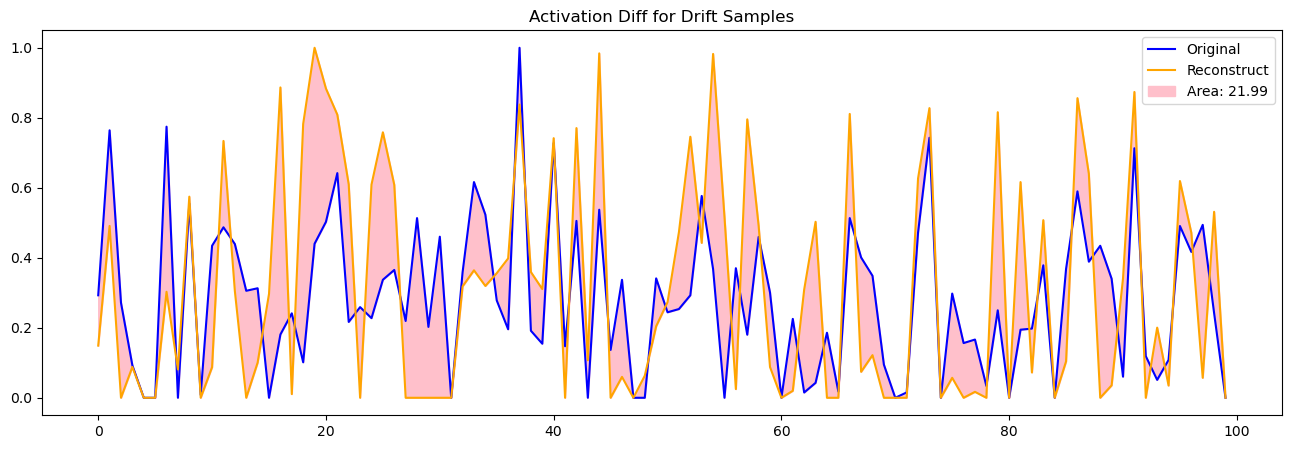

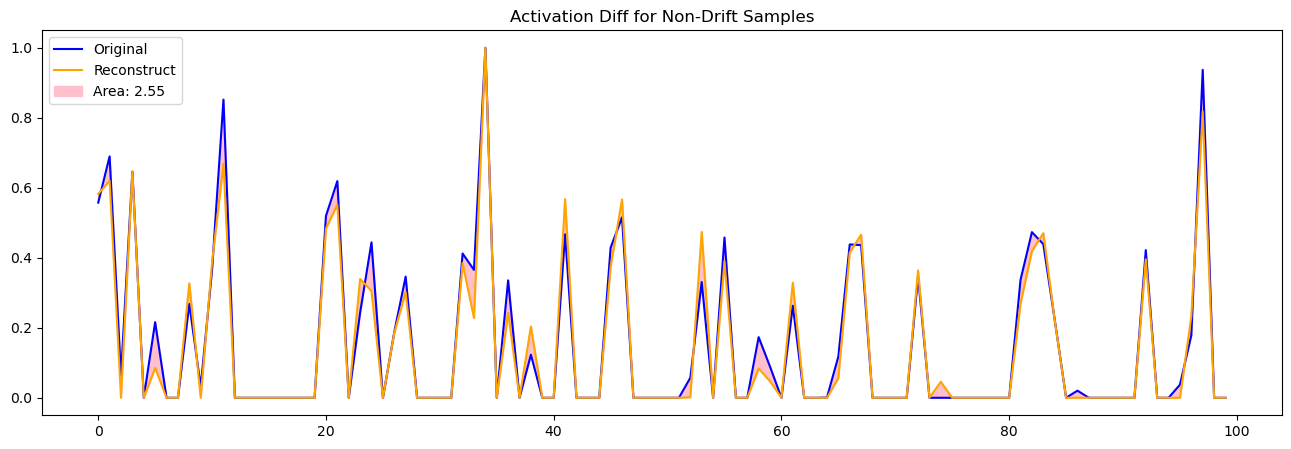

In [35]:
def plot_ood_id_diff_figures(dream_model, layer_names=['dropout'], pred_layer_name='clf_2', desc=''):
    data = X_drift[:1]
    fig, ax = plt.subplots(figsize=(16,5))
    # visualize_cam_1d(dream_model.f1, data)
    cam0 = visualize_cam_1d(dream_model.f1, data, layer_names=layer_names, pred_layer_name=pred_layer_name, tabular=True)[0]
    line_ori, = ax.plot(np.arange(len(cam0)), cam0, color='b', label='Original')

    emb = dream_model.encoder.predict(data)
    rec = dream_model.decoder.predict(emb)
    # visualize_cam_1d(dream_model.f1, rec, del_emb=True)
    cam0_ = visualize_cam_1d(dream_model.f1, rec, layer_names=layer_names, pred_layer_name=pred_layer_name, tabular=True)[0]
    plt.title('Activation Diff for Drift Samples')
    # plt.fill_between(np.arange(len(cam0)), cam0, color='r')
    # ax.fill_between(np.arange(len(cam0)), cam0, cam0_, color='pink')
    diff_auc, a0 = plot_filled_cam_with_area(cam0, cam0_, ax)
    line_rec, = ax.plot(np.arange(len(cam0_)), cam0_, color='orange', label='Reconstruct')
    plt.legend(handles=[line_ori, line_rec, diff_auc])

    data = x_train[:1]
    fig, ax = plt.subplots(figsize=(16,5))
    # visualize_cam_1d(dream_model.f1, data)
    cam1 = visualize_cam_1d(dream_model.f1, data, layer_names=layer_names, pred_layer_name=pred_layer_name, tabular=True)[0]
    line_ori1, = ax.plot(np.arange(len(cam1)), cam1, color='b', label='Original')

    emb = dream_model.encoder.predict(data)
    rec = dream_model.decoder.predict(emb)
    # visualize_cam_1d(dream_model.f1, rec, del_emb=True)
    cam1_ = visualize_cam_1d(dream_model.f1, rec, layer_names=layer_names, pred_layer_name=pred_layer_name, tabular=True)[0]
    plt.title('Activation Diff for Non-Drift Samples')
    # ax.fill_between(np.arange(len(cam1)), cam1, cam1_, color='pink')
    diff_auc1, a1 = plot_filled_cam_with_area(cam1, cam1_, ax)
    line_rec1, = ax.plot(np.arange(len(cam1_)), cam1_, color='orange', label='Reconstruct')
    # plt.legend()
    plt.legend(handles=[line_ori1, line_rec1, diff_auc1])

    print(desc+'Drift Diff - Non-Drift Diff:', a0-a1)
    plt.show()

plot_ood_id_diff_figures(dream_model)

Drift Diff - Non-Drift Diff: 16.55268453201279


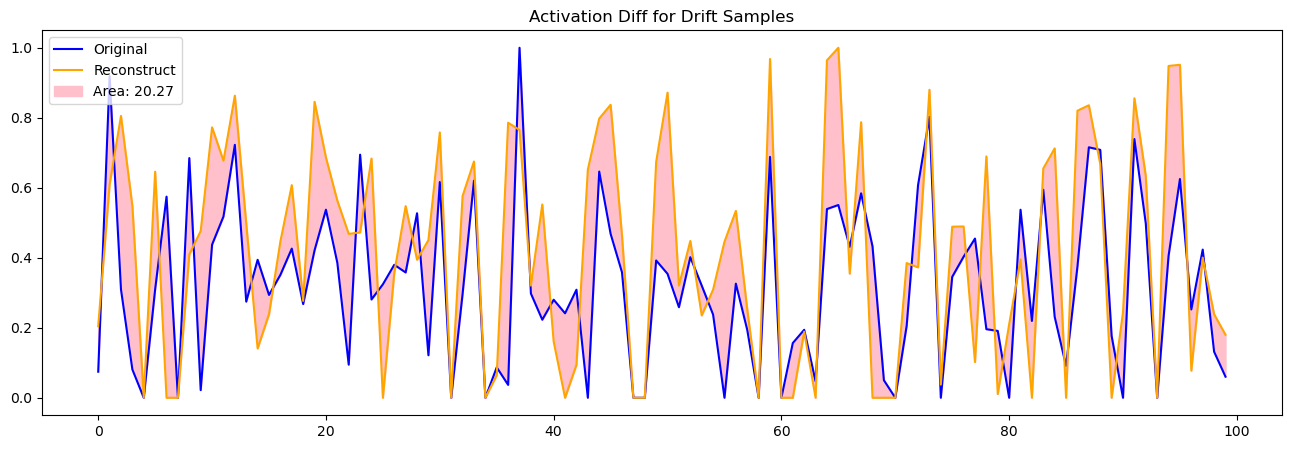

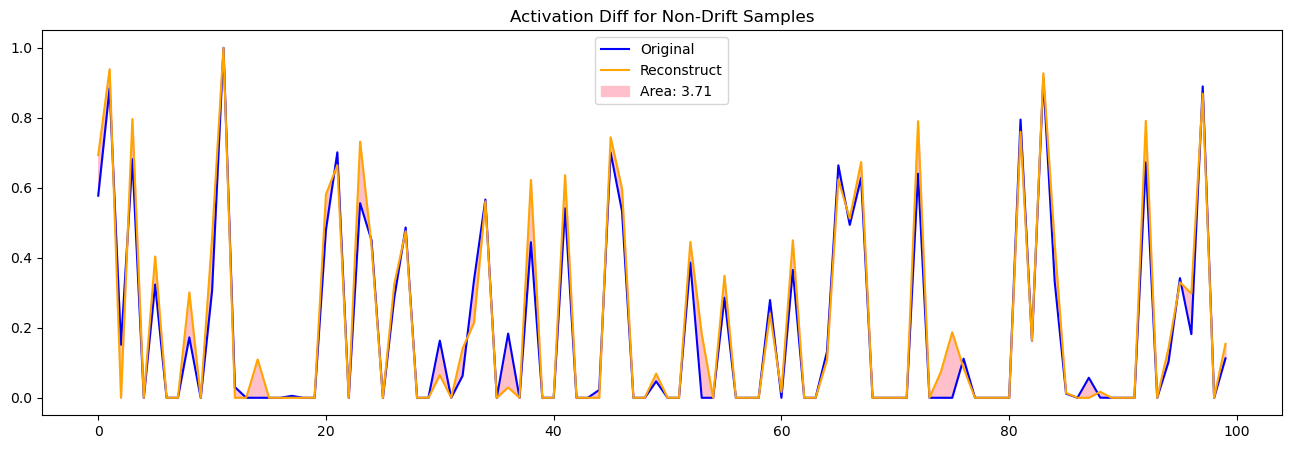

In [36]:
plot_ood_id_diff_figures(cade_model,layer_names=['dropout_2'])

=== DREAM Model === Drift Diff - Non-Drift Diff: 4.7373001128435135


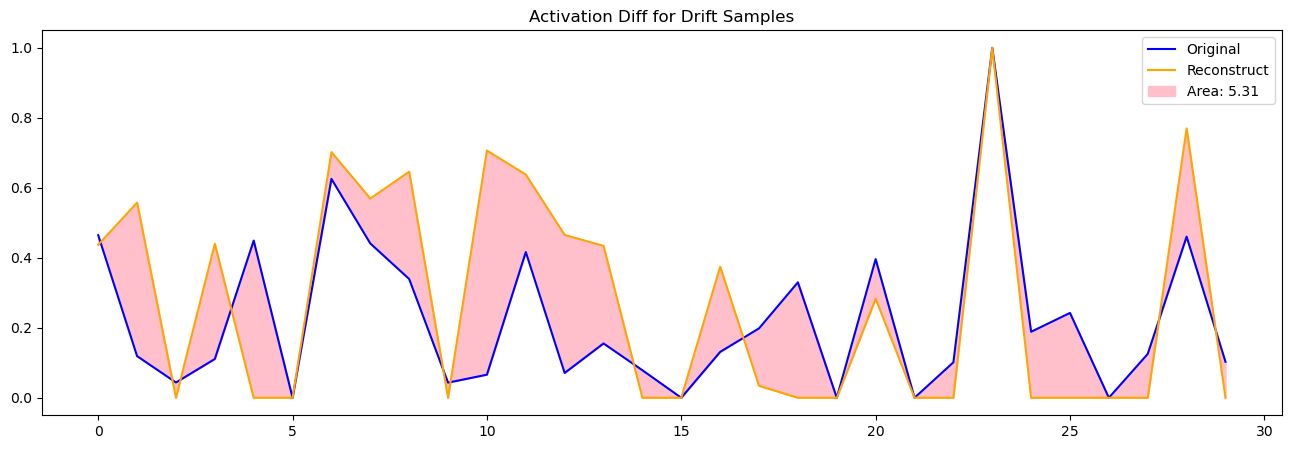

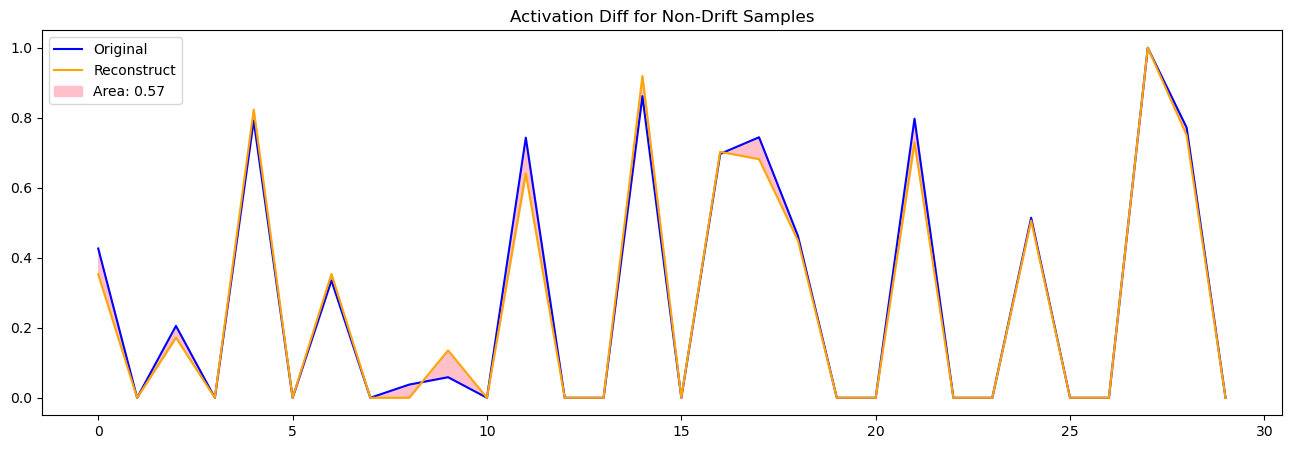

=== CADE Model === Drift Diff - Non-Drift Diff: 3.963832398876548


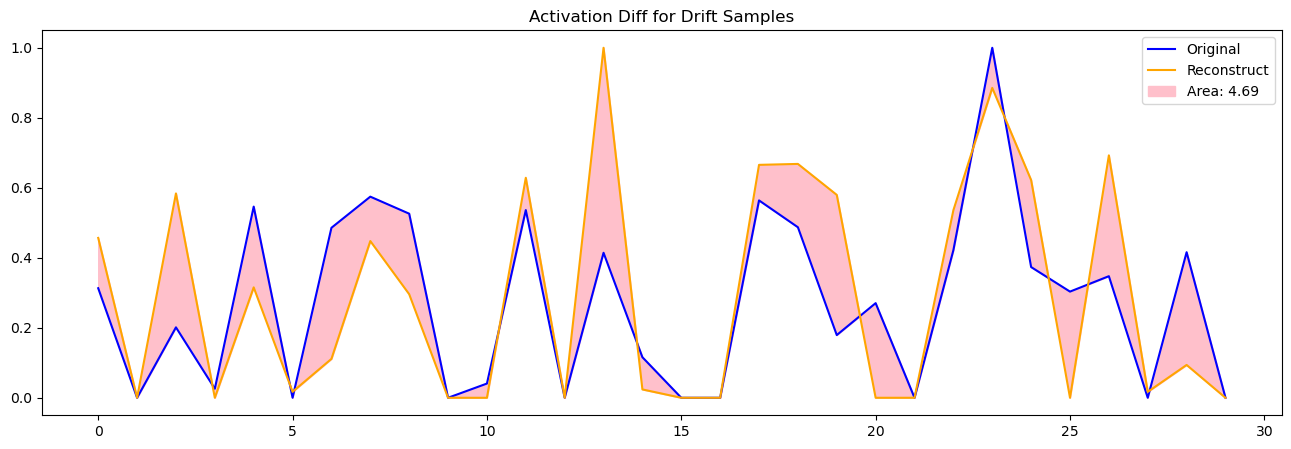

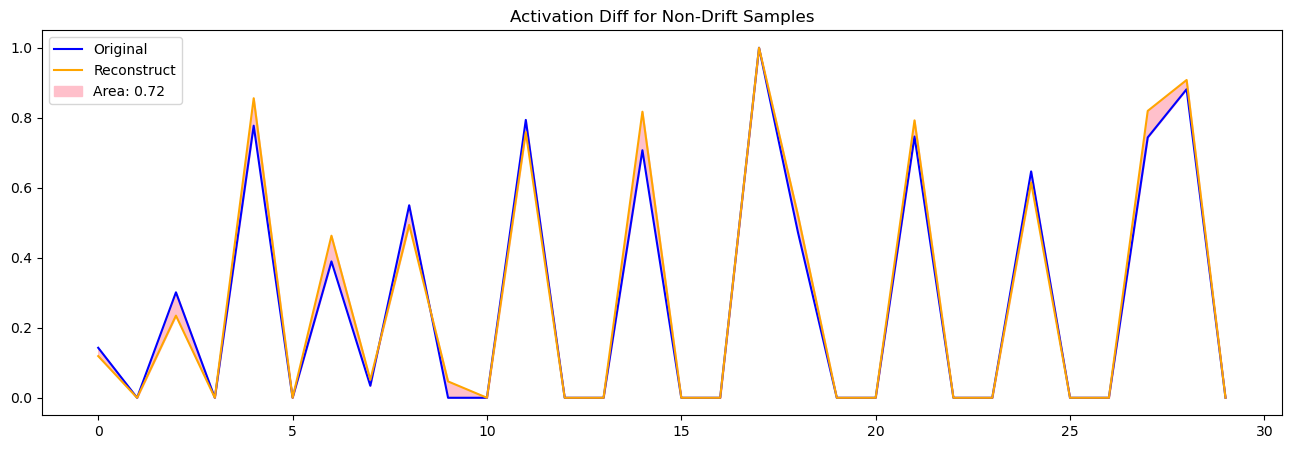

In [37]:
plot_ood_id_diff_figures(dream_model,layer_names=['dropout_1'], desc='=== DREAM Model === ')
plot_ood_id_diff_figures(cade_model,layer_names=['dropout_3'], desc='=== CADE Model === ')